In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [27]:
train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input/test.csv')
gender_submission = pd.read_csv('input/gender_submission.csv')

train.shape, test.shape, gender_submission.shape

((891, 12), (418, 11), (418, 2))

In [28]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 各カラムの意味
| 特徴量   | 意味                         | 補足  |
| --------|-----------------------------|------|
| Survived| 生き残ったか | 0 = No, 1 = Yes|
| Pclass| チケットのクラス | 1 = 1st, 2 = 2nd, 3 = 3rd|
| SibSp| 一緒に乗船した兄弟・配偶者の数||
| Parch| 一緒に乗船した親・子どもの数||
| Ticket| チケット番号||
| Fare| 賃料||
| Cabin| 船室番号||
| Embarked| 乗船した港 | C = Cherbourg, Q = Queenstown, S = Southampton|

In [30]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hunt, Mr. George Henry",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [31]:
test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"McNeill, Miss. Bridget",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [32]:
print(train.isna().sum())
print('--------')
print(test.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## 落とすカラム
- PassengerId : 単なる通し番号なのでモデルの精度には寄与しない
- Name : モデル精度に寄与しない
- Cabin : 欠損が多すぎる

## 要検証のカラム
- Ticket : 通し番号なら意味がないけど、同じ番号の乗客が複数いるのでその関係を紐解く
- Embarked : 生存率には関係なさそうだが、念のため確認

In [33]:
train['Ticket'].value_counts().head(20)

CA. 2343        7
1601            7
347082          7
3101295         6
CA 2144         6
347088          6
382652          5
S.O.C. 14879    5
LINE            4
349909          4
113760          4
2666            4
W./C. 6608      4
347077          4
19950           4
17421           4
113781          4
PC 17757        4
4133            4
PC 17755        3
Name: Ticket, dtype: int64

In [34]:
# 家族でまとめてチケットを買ったっぽい
train[train['Ticket'] == '347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S


In [35]:
# こちらは友人同士か？
train[train['Ticket'] == '1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


In [36]:
# こちらも家族っぽい
train[train['Ticket']=='CA. 2343']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


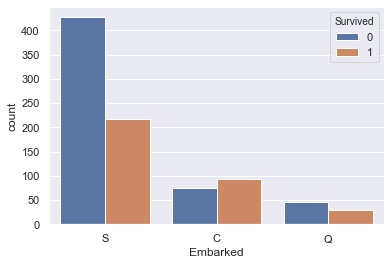

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.013166
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.169718
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.164681
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.032565
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.068900
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.040449
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.226311
Embarked,0.013166,-0.169718,0.164681,-0.032565,0.068900,0.040449,-0.226311,1.000000


In [37]:
sns.countplot(x='Embarked', data=train, hue='Survived')
plt.show()

df_enb = train.copy()
df_enb['Embarked'] = df_enb['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_enb.corr()

In [38]:
print(dict(train['Embarked'].value_counts()))
df_embarked = train.groupby('Embarked').sum()
df_embarked = df_embarked[['Survived']]
df_embarked = pd.concat([df_embarked, train['Embarked'].value_counts()], axis=1)
df_embarked['Survive_rate'] = df_embarked.apply(lambda r: r['Survived'] / r['Embarked'] *100, axis=1)
df_embarked

{'S': 644, 'C': 168, 'Q': 77}


,Survived,Embarked,Survive_rate
C,93,168,55.357143
Q,30,77,38.961039
S,217,644,33.695652


#### Ticket
- 家族や友人などでまとめて買ったチケットが同じ番号になっているように見える
- 船内に知り合いがいるという新たなパラメータを作る際には使えるかもしれない

#### Embarked
- Cherbourgで乗船した乗客の生存率が高い

## 不要カラムの削除
- Embarkedは一旦残す
- Ticketは削除

In [39]:
del_columns = ['PassengerId', 'Name', 'Cabin', 'Ticket']
train = train.drop(del_columns, axis=1)
test  = test.drop(del_columns, axis=1)

In [40]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## カテゴリ変数を数値に置き換える

In [ ]:
dataset = [train, test]
for data in dataset:
    # 性別
    data['Sex'] = data['Sex'].map({'male': 0, 'female':1})

# 乗船港
train = pd.get_dummies(train, drop_first=True)
test  = pd.get_dummies(test,  drop_first=True)

In [43]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,0,0
2,1,3,1,26.0,0,0,7.9250,0,1
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,1


In [44]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,7.8292,1,0
1,3,1,47.0,1,0,7.0000,0,1
2,2,0,62.0,0,0,9.6875,1,0
3,3,0,27.0,0,0,8.6625,0,1
4,3,1,22.0,1,1,12.2875,0,1


## 欠損値を埋める

In [46]:
train.isna().sum(), test.isna().sum()

(Survived        0
 Pclass          0
 Sex             0
 Age           177
 SibSp           0
 Parch           0
 Fare            0
 Embarked_Q      0
 Embarked_S      0
 dtype: int64,
 Pclass         0
 Sex            0
 Age           86
 SibSp          0
 Parch          0
 Fare           1
 Embarked_Q     0
 Embarked_S     0
 dtype: int64)

In [48]:
# 中央値で埋める
age_median = train['Age'].median()
print('Age Median:', age_median)
fare_median = train['Fare'].median()
print('Fare Median:', fare_median)

dataset = [train, test]
for data in dataset:
    data['Age'] = data['Age'].fillna(age_median)
    data['Fare'] = data['Fare'].fillna(fare_median)

Age Median: 28.0
Fare Median: 14.4542


In [49]:
train.isna().sum(), test.isna().sum()

(Survived      0
 Pclass        0
 Sex           0
 Age           0
 SibSp         0
 Parch         0
 Fare          0
 Embarked_Q    0
 Embarked_S    0
 dtype: int64,
 Pclass        0
 Sex           0
 Age           0
 SibSp         0
 Parch         0
 Fare          0
 Embarked_Q    0
 Embarked_S    0
 dtype: int64)

## 訓練データとテストデータに分割

In [50]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,0,0
2,1,3,1,26.0,0,0,7.9250,0,1
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0,1
887,1,1,1,19.0,0,0,30.0000,0,1
888,0,3,1,28.0,1,2,23.4500,0,1
889,1,1,0,26.0,0,0,30.0000,0,0


In [51]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,7.8292,1,0
1,3,1,47.0,1,0,7.0000,0,1
2,2,0,62.0,0,0,9.6875,1,0
3,3,0,27.0,0,0,8.6625,0,1
4,3,1,22.0,1,1,12.2875,0,1
...,...,...,...,...,...,...,...,...
413,3,0,28.0,0,0,8.0500,0,1
414,1,1,39.0,0,0,108.9000,0,0
415,3,0,38.5,0,0,7.2500,0,1
416,3,0,28.0,0,0,8.0500,0,1


In [52]:
# 訓練用データ
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,0,0
2,3,1,26.0,0,0,7.9250,0,1
3,1,1,35.0,1,0,53.1000,0,1
4,3,0,35.0,0,0,8.0500,0,1


In [53]:
# テスト用データ
X_test = test
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,7.8292,1,0
1,3,1,47.0,1,0,7.0000,0,1
2,2,0,62.0,0,0,9.6875,1,0
3,3,0,27.0,0,0,8.6625,0,1
4,3,1,22.0,1,1,12.2875,0,1


## モデル生成
- パイプラインとGridSearchで良いパラメータを探す

In [54]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [55]:
# パイプライン
estimator = [('scaler', MinMaxScaler()),
             ('clf', SVC())]

pipe = Pipeline(estimator)

# Grid Search
param = {'clf__C': 10**np.arange(0, 10),
         'clf__kernel': ['rbf', 'linear']}

gs = GridSearchCV(pipe, param, n_jobs=-1, verbose=2)

In [82]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 43.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False

In [86]:
gs.best_params_, gs.best_score_, gs.best_estimator_

({'clf__C': 10, 'clf__kernel': 'rbf'},
 0.8193019898311468,
 Pipeline(memory=None,
          steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                 ('clf',
                  SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovr', degree=3,
                      gamma='scale', kernel='rbf', max_iter=-1,
                      probability=False, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False))

## モデルの保存
- [参考Web](https://localab.jp/blog/save-and-load-machine-learning-models-in-python-with-scikit-learn/)

In [56]:
import pickle
fname = 'output/gs_trained_titanic_test.sav'

In [85]:
pickle.dump(gs, open(fname, 'wb'))

## モデルのロード
- 調整の結果も出力

In [27]:
# ロードしてみる
gs_loaded = pickle.load(open(fname, 'rb'))

In [28]:
gs_loaded.best_params_, gs_loaded.best_score_, gs_loaded.best_estimator_

({'clf__C': 10, 'clf__kernel': 'rbf'},
 0.8193019898311468,
 Pipeline(memory=None,
          steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                 ('clf',
                  SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovr', degree=3,
                      gamma='scale', kernel='rbf', max_iter=-1,
                      probability=False, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False))

In [29]:
C_range = 10**np.arange(0, 10)
res = gs_loaded.cv_results_

In [30]:
C_range.shape, res['mean_fit_time'].shape

((10,), (20,))

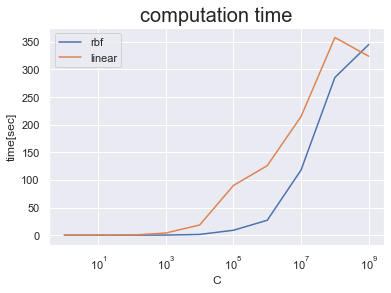

In [31]:
# 処理時間のプロット
s_rbf = (res['param_clf__kernel'] == 'rbf')
plt.plot(C_range, res['mean_fit_time'][s_rbf], label='rbf')

s_linear = (res['param_clf__kernel'] == 'linear')
plt.plot(C_range, res['mean_fit_time'][s_linear], label='linear')

plt.xscale('log')
plt.xlabel('C', fontsize=12)
plt.ylabel('time[sec]', fontsize=12)
plt.title('computation time', fontsize=20)
plt.legend()
plt.show()

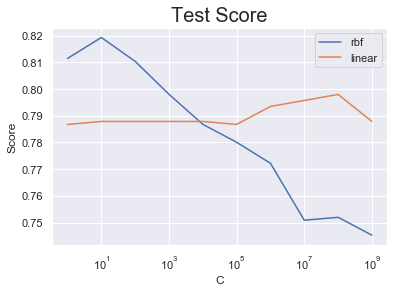

In [32]:
# 精度のプロット
plt.plot(C_range, res['mean_test_score'][s_rbf], label='rbf')
plt.plot(C_range, res['mean_test_score'][s_linear], label='linear')

plt.legend()
plt.xscale('log')
plt.xlabel('C', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Test Score', fontsize=20)
plt.show()

In [33]:
gs_loaded.cv_results_

{'mean_fit_time': array([3.13665390e-02, 2.80607700e-02, 2.92960644e-02, 2.49231339e-02,
        4.94768620e-02, 1.06295443e-01, 1.79617405e-01, 3.87286382e+00,
        1.34184403e+00, 1.83880243e+01, 8.85750065e+00, 8.98520918e+01,
        2.69584633e+01, 1.25726404e+02, 1.17888616e+02, 2.14605454e+02,
        2.85239785e+02, 3.57567170e+02, 3.44736662e+02, 3.23691652e+02]),
 'std_fit_time': array([6.45918265e-03, 1.01130194e-02, 4.75690708e-03, 8.71054860e-03,
        8.54477493e-03, 4.67602395e-02, 5.47520764e-02, 3.93274387e+00,
        7.13810691e-01, 9.56908994e+00, 1.80153828e+00, 3.01544059e+01,
        8.72626931e+00, 3.27376877e+01, 8.02807852e+01, 6.65538644e+00,
        2.36760161e+02, 1.78720947e+02, 9.58086779e+01, 1.51301700e+02]),
 'mean_score_time': array([0.00596747, 0.00493522, 0.00530028, 0.0030272 , 0.00481801,
        0.003122  , 0.0037509 , 0.00325708, 0.00367332, 0.00344996,
        0.00381145, 0.00370617, 0.00479217, 0.00555763, 0.00622525,
        0.00327158, 

## 予測の作成

In [34]:
y_pred = gs_loaded.predict(X_test)

In [35]:
y_pred

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [36]:
df_result = gender_submission.copy()
df_result['Survived'] = y_pred.astype(int)
df_result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [37]:
# 予測の保存
df_result.to_csv('output/submission.csv', index=False)